In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import plotly.graph_objects as go
import plotly.subplots as sp

In [ ]:
#load dataset
df = pd.read_csv("../Classification/train_data_feature_engineered.csv")  #training dataset
df_test = pd.read_csv("../Classification/test_data_feature_engineered.csv") #testing dataset


# Display first few rows
print(df.head())


   Month  Year         Country  Departures  Arrivals  Total Holidays  \
0      1  2000          France     11098.0   11469.0        1.014816   
1      1  2000          Europe    118255.0  119735.0        1.014816   
2      1  2000   North America     29012.0   26225.0        1.014816   
3      1  2000  United Kingdom     46677.0   45630.0        1.014816   
4      1  2000         Germany     23172.0   24251.0        1.014816   

   Inflation  Month_sin  Month_cos  Total_Traffic  
0  -0.279182        0.5   0.866025        22567.0  
1  -0.279182        0.5   0.866025       237990.0  
2  -0.279182        0.5   0.866025        55237.0  
3  -0.570839        0.5   0.866025        92307.0  
4  -0.395845        0.5   0.866025        47423.0  


In [36]:
print(df.isnull().sum())  # Check for missing values in your data


Month             0
Year              0
Country           0
Departures        0
Arrivals          0
Total Holidays    0
Inflation         0
Month_sin         0
Month_cos         0
Total_Traffic     0
dtype: int64


In [37]:


# One-hot encode 'Country'
df_one_hot = pd.get_dummies(df['Country'], prefix='Country', drop_first=True)  # Drop first to avoid redundancy


In [38]:

# Scale numerical features
scaler = StandardScaler()

df_scaled_numeric = pd.DataFrame(scaler.fit_transform(df_one_hot), columns=df_one_hot.columns)

# Merge scaled numerical data, categorical data (Month, Year), and one-hot Country encoding
df_final = pd.concat([df_scaled_numeric, df[['Year', 'Month']], df_one_hot], axis=1)

# Ensure all features are numeric before clustering
print(df_final.dtypes)

Country_France             float64
Country_Germany            float64
Country_Hong Kong          float64
Country_Indonesia          float64
Country_Japan              float64
Country_Mainland China     float64
Country_Malaysia           float64
Country_Middle East        float64
Country_North America      float64
Country_North East Asia    float64
Country_Oceania            float64
Country_Philippines        float64
Country_South Asia         float64
Country_South East Asia    float64
Country_Thailand           float64
Country_United Kingdom     float64
Country_Vietnam            float64
Year                         int64
Month                        int64
Country_France                bool
Country_Germany               bool
Country_Hong Kong             bool
Country_Indonesia             bool
Country_Japan                 bool
Country_Mainland China        bool
Country_Malaysia              bool
Country_Middle East           bool
Country_North America         bool
Country_North East A

In [39]:
# Check if df_scaled has NaN or Infinite values
print(df_final.isnull().sum())  # Check NaNs
print(np.isinf(df_final).sum())  # Check infinite values


Country_France             0
Country_Germany            0
Country_Hong Kong          0
Country_Indonesia          0
Country_Japan              0
Country_Mainland China     0
Country_Malaysia           0
Country_Middle East        0
Country_North America      0
Country_North East Asia    0
Country_Oceania            0
Country_Philippines        0
Country_South Asia         0
Country_South East Asia    0
Country_Thailand           0
Country_United Kingdom     0
Country_Vietnam            0
Year                       0
Month                      0
Country_France             0
Country_Germany            0
Country_Hong Kong          0
Country_Indonesia          0
Country_Japan              0
Country_Mainland China     0
Country_Malaysia           0
Country_Middle East        0
Country_North America      0
Country_North East Asia    0
Country_Oceania            0
Country_Philippines        0
Country_South Asia         0
Country_South East Asia    0
Country_Thailand           0
Country_United

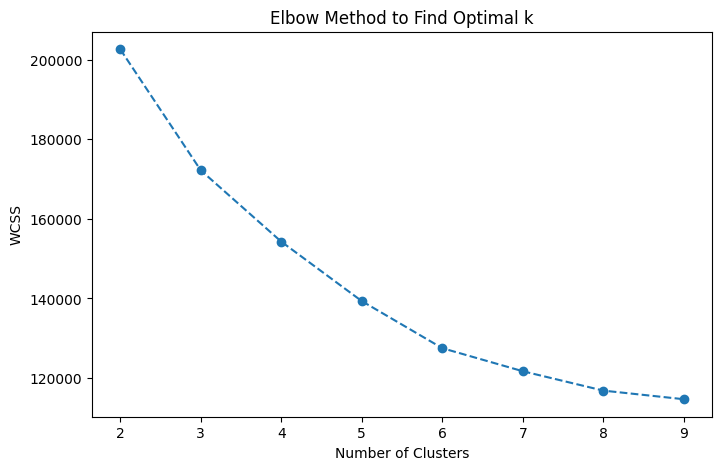

In [40]:
# Determine the optimal number of clusters using the elbow and silhouette method
wcss = []  # Within-cluster sum of squares
k_values = range(2, 10)  # Test cluster numbers from 2 to 9

# Elbow Method (WCSS plot)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_final)
    wcss.append(kmeans.inertia_)  # Inertia is the sum of squared distances to cluster centers

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method to Find Optimal k')
plt.show()

In [41]:
# Silhouette Score for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_final)
    score = silhouette_score(df_final, cluster_labels)
    print(f"For k={k}, Silhouette Score: {score:.4f}")
#choose the highest silhouette score and when the elbow bends

For k=2, Silhouette Score: 0.3542
For k=3, Silhouette Score: 0.2230
For k=4, Silhouette Score: 0.2139
For k=5, Silhouette Score: 0.1838
For k=6, Silhouette Score: 0.1758
For k=7, Silhouette Score: 0.1614
For k=8, Silhouette Score: 0.1447
For k=9, Silhouette Score: 0.1355


By doing the elbow method and calculating the silhouette score, 3 clusters seem the most fitting and hence we are going to use 3 clusters for the K-Means clustering.

In [42]:
from sklearn.cluster import KMeans

# Apply K-Means clustering 
kmeans = KMeans(n_clusters=3, random_state=42)
df["Traffic_Class"] = kmeans.fit_predict(df[["Total_Traffic"]])
df_test["Traffic_Class"] = kmeans.predict(df_test[["Total_Traffic"]])


In [43]:
# View the cluster centers
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)
# Get descriptive statistics for each cluster
cluster_summary = df.groupby("Traffic_Class")["Total_Traffic"].describe()
print("Cluster Summary Statistics:\n", cluster_summary)


Cluster Centers:
 [[ 139848.16463909]
 [1723826.88516746]
 [ 568692.45179584]]
Cluster Summary Statistics:
                 count          mean            std        min         25%  \
Traffic_Class                                                               
0              3696.0  1.396740e+05  102232.556865      305.0    50228.75   
1               210.0  1.721080e+06  414897.283802  1146961.0  1344567.50   
2              1060.0  5.675404e+05  195612.490293   354290.0   421511.50   

                     50%         75%        max  
Traffic_Class                                    
0               116793.5   227980.75   354265.0  
1              1647068.5  2074473.25  2707064.0  
2               509747.5   641875.75  1144807.0  


From the KMeans output, we can infer:

Cluster 0 contains records with low traffic, Cluster 1 high traffic, and Cluster 2 moderate traffic.

C:\Users\Vianiece\AppData\Local\Temp\ipykernel_28204\3707333850.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




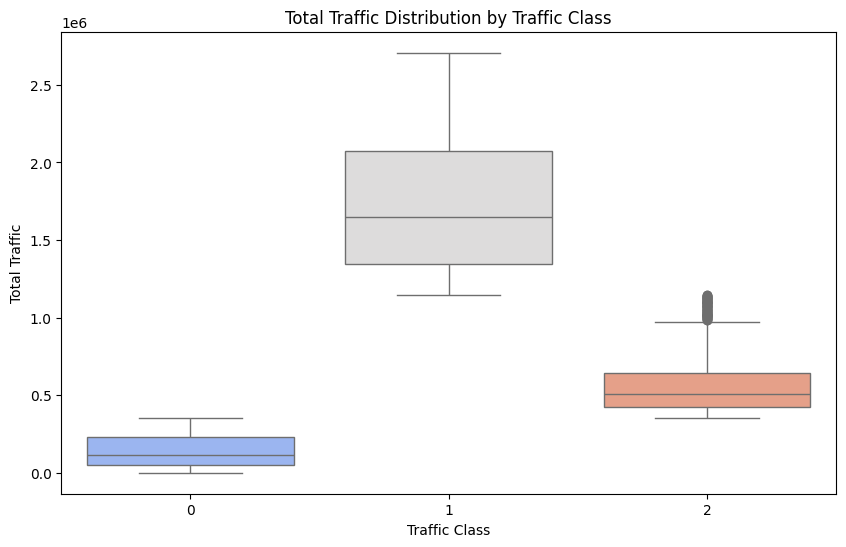

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Traffic_Class"], y=df["Total_Traffic"], palette="coolwarm")
plt.title("Total Traffic Distribution by Traffic Class")
plt.xlabel("Traffic Class")
plt.ylabel("Total Traffic")
plt.show()


C:\Users\Vianiece\AppData\Local\Temp\ipykernel_28204\1939079886.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




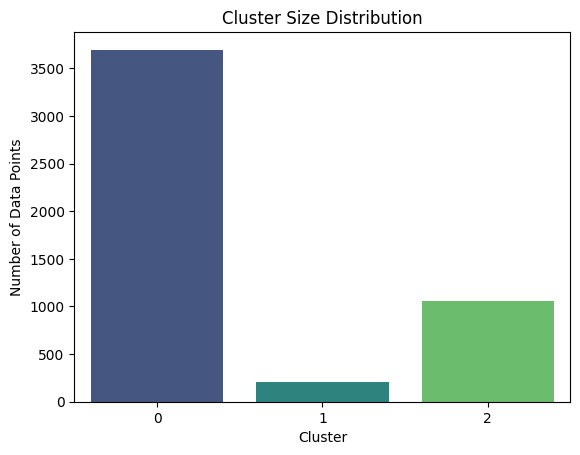

In [45]:
#visualise clusters - cluster size distribution

sns.countplot(data=df, x='Traffic_Class', palette='viridis')
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Data Points")
plt.show()


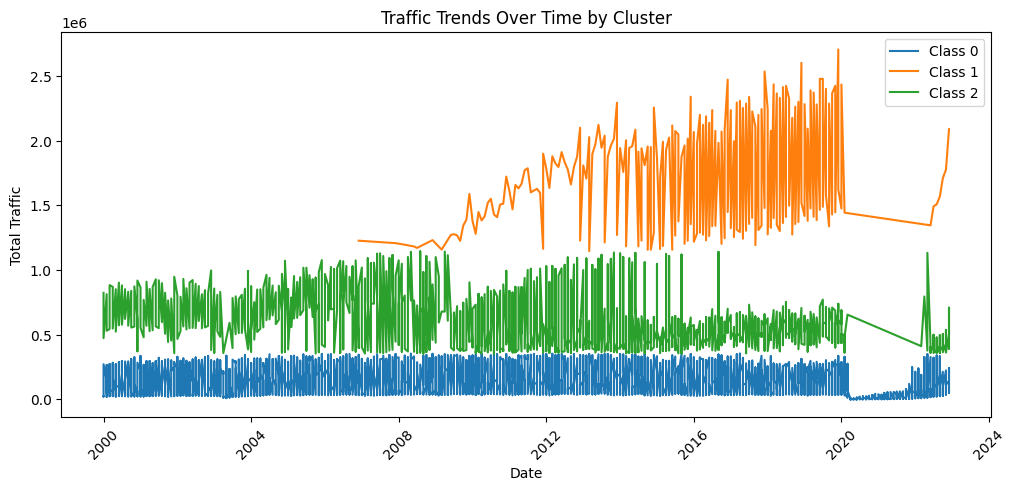

In [46]:
df["Date"] = pd.to_datetime(df[["Year", "Month"]].assign(DAY=1))

plt.figure(figsize=(12, 5))
for cluster in sorted(df["Traffic_Class"].unique()):
    cluster_data = df[df["Traffic_Class"] == cluster]
    plt.plot(cluster_data["Date"], cluster_data["Total_Traffic"], label=f"Class {cluster}")

plt.xlabel("Date")
plt.ylabel("Total Traffic")
plt.title("Traffic Trends Over Time by Cluster")
plt.legend()
plt.xticks(rotation=45)
plt.show()


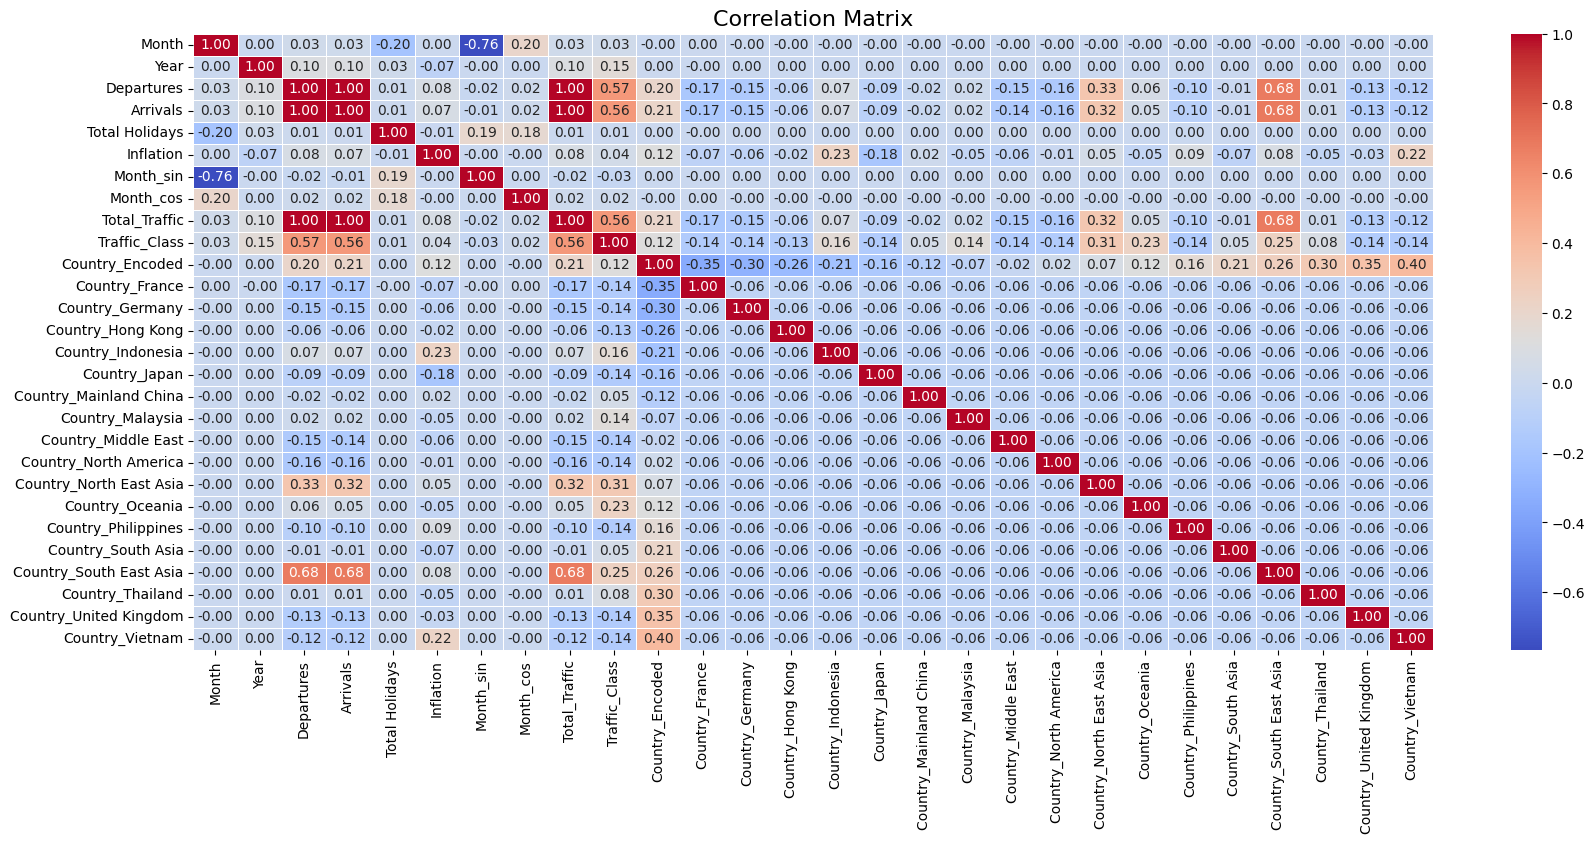

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Set up the figure size for better readability
plt.figure(figsize=(20, 8))  # Adjust the size as needed

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

# Add a title
plt.title('Correlation Matrix', fontsize=16)

# Show the plot
plt.show()


In [ ]:
# Save Traffic_Class to train and test CSV files - final one

# Save the train DataFrame with the new Traffic_Class column
df.to_csv('train_data_with_traffic_class.csv', index=False)

# Save the test DataFrame with the new Traffic_Class column
df_test.to_csv('test_data_with_traffic_class.csv', index=False)

print("Files saved with Traffic_Class column!")

Files saved with Traffic_Class column!
